In [16]:
from shapely import geometry
import geopandas as gpd
from geojson import Feature
import matplotlib.pyplot as plt

In [2]:
p1 = geometry.Polygon([[0,0],[1,0],[1,1],[0,1]])
p2 = geometry.Polygon([[0,1],[1,1],[1,2],[0,2]])
p3 = geometry.Polygon([[1,1.25],[1,2],[2,2],[2,1.25]])
p4 = geometry.Polygon([[1.5,0],[1.5,1],[2,1],[2,0]])

In [3]:
f1 = Feature(geometry=p1, properties={'A1':5,'A2':2,'node':'foo','id':'p1'})
f2 = Feature(geometry=p2, properties={'A1':1,'A2':2,'node':'foo','id':'p2'})
f3 = Feature(geometry=p3, properties={'A1':7,'A2':2,'node':'foo','id':'p3'})
f4 = Feature(geometry=p4, properties={'A1':2,'A2':2,'node':'bar','id':'p4'})

In [4]:
gdf = gpd.GeoDataFrame.from_features([f1,f2,f3,f4]).set_index('id')

<AxesSubplot:>

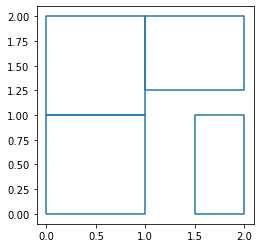

In [9]:
gdf.boundary.plot()

# A Simple 'get neighbours' example
How to get the neighbouring polygons?

In [5]:
[tuple(e) for e in gpd.sjoin(gdf,gdf).reset_index()[['id','index_right']].values.tolist() if e[0]!=e[1]]

[('p2', 'p1'), ('p1', 'p2'), ('p3', 'p2'), ('p2', 'p3')]

In [7]:
gdf.dissolve('node')

,geometry,A1,A2
node,,,
bar,"POLYGON ((1.50000 0.00000, 1.50000 1.00000, 2....",2,2
foo,"POLYGON ((1.00000 0.00000, 0.00000 0.00000, 0....",5,2


# An Advanced application: Flow Capacity between neighbours

Assume: Both polygon and line dataframes are large, so cannot fit into memory

In [26]:
ls0 = geometry.LineString([[0.1,0.25],[0.25,0.1]])
ls1 = geometry.LineString([[0.5,0.5],[0.5,1.5]])
ls2 = geometry.LineString([[1.5,1.5],[0.6,1.5],[0.6,0.5]])
ls3 = geometry.LineString([[0.65,1.5],[1.7,0.5]])
ls4 = geometry.LineString([[1.7,1.7],[1.7,0.5]])

fls0 = Feature(geometry=ls0, properties={'capacity':10})
fls1 = Feature(geometry=ls1, properties={'capacity':5})
fls2 = Feature(geometry=ls2, properties={'capacity':2})
fls3 = Feature(geometry=ls3, properties={'capacity':3})
fls4 = Feature(geometry=ls4, properties={'capacity':7})

In [28]:
gdf_line = gpd.GeoDataFrame.from_features([fls0,fls1,fls2,fls3,fls4])

<AxesSubplot:>

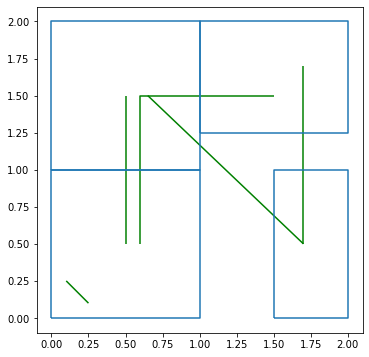

In [29]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
gdf_line.plot(color='g', ax=ax)
gdf.boundary.plot(ax=ax)

In [54]:
from itertools import groupby

In [83]:
def group2neighbours(group_df, group_idx, princip):
    ll= group_df['index_right'].values.tolist()
    # remove duplicates
    ll = [key for key, _ in groupby(ll)]
    ii = ll.index(princip)
    neighbours = ll[max(ii-1,0):ii+2]
    # sort to make sure the order is unique
    return [tuple([group_idx]+sorted([n_0, n_1])) for n_0, n_1 in list(zip(neighbours[:-1],neighbours[1:]))]

In [84]:
# for each polygon boundary, get intersecting lines..

# undirected graph
all_edges = {}

# iterate rather than explode a big spatial join because this would be e.g. a db query in the future
for idx, row in gdf.iterrows():
    geom = row['geometry']


    # get the intersecting lines
    # then cast those lines to multipoint and get the multipoint intersections with the polygons
    # ... same here re: a db query
    sj_gdf = gpd.sjoin(gdf_line.loc[gdf_line.intersects(geom.exterior)].set_geometry('mp'),gdf)

    # get all edges

    for group_idx, group_df in sj_gdf.reset_index().groupby('index'):
        # reduce each to a unique ordered list
        new_edges = group2neighbours(group_df, group_idx, idx)
        for e in new_edges:
            if e not in all_edges:
                all_edges[e] = group_df.iloc[0]['capacity']

In [85]:
# now for all_edges, sum pair relationship

# get unique edge pairs first

unique_pairs = list(set([tuple([e[1],e[2]]) for e in all_edges.keys()]))

sum_edges = {}
for e in unique_pairs:
    sum_edges[e] = sum([v for k,v in all_edges.items() if k[1]==e[0] and k[2]==e[1]])

In [86]:
sum_edges

{('p3', 'p4'): 7, ('p2', 'p4'): 3, ('p2', 'p3'): 2, ('p1', 'p2'): 7}